## Alchemical free energy calculation with openmm
* https://openmm.github.io/openmm-cookbook/latest/notebooks/tutorials/Alchemical_free_energy_calculations.html
* https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005659

### See also
* https://github.com/choderalab/yank?tab=readme-ov-file - YANK: Yet Another Noisy Knetic (YANK) is a GPU-accelerated, Python and YAML-based toolkit for alchemical free energy calculations.
* https://link.springer.com/article/10.1007/s10822-013-9689-8

### Define alchemically-modified potentials
* create a simple Lennard-Jones fluid to represent liquid argon at 120 K and 80 atm, which can be conveniently done using the testsystems module of the conda-installable openmmtools package


In [51]:
#!conda install -c conda-forge openmmtools

In [52]:
import numpy as np
from openmm.app import *
from openmm import *
from openmm.unit import *
from openmmtools.testsystems import LennardJonesFluid

In [53]:
# Simulation settings
# pressure = 80*atmospheres
# temperature = 120*kelvin
pressure = 1 * atmospheres
temperature = 300 * kelvin
collision_rate = 5 / picoseconds
timestep = 2.5 * femtoseconds

In [54]:
# Create a Lennard Jones test fluid
sigma = 3.4 * angstrom
epsilon = 0.238 * kilocalories_per_mole
fluid = LennardJonesFluid(
    sigma=sigma, epsilon=epsilon, cutoff=9 * angstrom, box_edge=40 * angstrom
)
[topology, system, positions] = [fluid.topology, fluid.system, fluid.positions]

In [55]:
topology

<Topology; 1 chains, 1000 residues, 1000 atoms, 0 bonds>

In [56]:
system

<openmm.openmm.System; proxy of <Swig Object of type 'OpenMM::System *' at 0x751cd8daca50> >

In [57]:
positions

Quantity(value=array([[0.       , 0.       , 0.       ],
       [4.61451  , 4.61451  , 4.61451  ],
       [6.9217653, 2.307255 , 6.9217653],
       ...,
       [8.372812 , 6.0835824, 9.093829 ],
       [6.065557 , 3.7763276, 6.7865744],
       [1.4510471, 8.390838 , 2.1720643]], dtype=float32), unit=nanometer)

In [58]:
# Add a barostat
barostat = MonteCarloBarostat(pressure, temperature)
system.addForce(barostat)

1

* To allow one of the Lennard-Jones particles to be alchemically eliminated, we create a CustomNonbondedForce that will compute the interactions between the alchemical particle and the remaining chemical particles using a softcore potential. 
* The alchemically-modified particle has its Lennard-Jones well depth (epsilon parameter) set to zero in the original NonbondedForce, while the CustomNonbondedForce is set to evaluate only the interactions between the alchemically-modified particle and the remaining particles using addInteractionGroup() to specify only interactions between these groups are to be computed. 
* A global context parameter lambda is created to control the coupling of the alchemically-modified particle with the rest of the system during the simulation. The Lennard-Jones parameters sigma and epsilon are implemented as per-particle parameters, though this is not strictly necessary in this case since all particles are equivalent.
### See also:
* [Lecture 06, concept 22: Binding free energy - the free energy cycle & DDG values](https://www.youtube.com/watch?v=LJOmgrwncY0)


In [59]:
# Retrieve the NonbondedForce
forces = {force.__class__.__name__: force for force in system.getForces()}
nbforce = forces["NonbondedForce"]

In [60]:
forces  # dictionary of forces

{'NonbondedForce': <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x751cd8dad620> >,
 'MonteCarloBarostat': <openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x751cd8dad8c0> >}

In [61]:
# Make two sets of particles, one that contains just the particle we will alchemically annihilate
# and the other which contains all the other particles.
alchemical_particles = set([0])  # The first particle (atom index 0)
chemical_particles = (
    set(range(system.getNumParticles())) - alchemical_particles
)  # All other particles (atoms)

In [62]:
# Define the energy function for the CustomNonbondedForce
# when lambda is 1.0 it is a normal LJ potential, when lambda is 0.0 the interaction vanishes
energy_function = "lambda*4*epsilon*x*(x-1.0); x = (sigma/reff_sterics)^6;"
energy_function += "reff_sterics = sigma*(0.5*(1.0-lambda) + (r/sigma)^6)^(1/6);"
energy_function += "sigma = 0.5*(sigma1+sigma2); epsilon = sqrt(epsilon1*epsilon2);"
custom_force = CustomNonbondedForce(energy_function)

#### Lennard-Jones Potential, and custom nonbonded force
* #TODO
* https://en.wikipedia.org/wiki/Lennard-Jones_potential#Long-range_interactions


In [63]:
# Add lambda as a parameter we can change during the simulation
custom_force.addGlobalParameter("lambda", 1.0)

0

In [64]:
# set the values of sigma and epsilon by copying them from the existing NonBondedForce
custom_force.addPerParticleParameter("sigma")
custom_force.addPerParticleParameter("epsilon")
for index in range(system.getNumParticles()):
    [charge, sigma, epsilon] = nbforce.getParticleParameters(index)
    custom_force.addParticle([sigma, epsilon])
    if index in alchemical_particles:  # atom index 0
        # remove the alchemical particle from the existing NonBondedForce
        nbforce.setParticleParameters(index, charge * 0, sigma, epsilon * 0)

In [65]:
# Set the custom force to occur between just the alchemical particle and the other particles
custom_force.addInteractionGroup(alchemical_particles, chemical_particles)
system.addForce(custom_force)

2

## Simulating alchemically-modified systems

In [66]:
# Create an integrator
integrator = LangevinIntegrator(temperature, collision_rate, timestep)

In [67]:
# Create a simulation
platform = Platform.getPlatformByName("CUDA")
simulation = Simulation(topology, system, integrator, platform)
simulation.context.setPositions(positions)

In [68]:
# Minimize energy
print("Minimizing energy...")
# LocalEnergyMinimizer.minimize(context)
simulation.minimizeEnergy()

Minimizing energy...


In [69]:
# Collect data

# number of steps per sample
nsteps = 2500
# number of samples to collect per alchemical state
niterations = 500

In [70]:
lambdas = np.linspace(1.0, 0.0, 10)  # alchemical lambda schedule
nstates = len(lambdas)
u_kln = np.zeros([nstates, nstates, niterations], np.float64)
u_kln.shape

(10, 10, 500)

In [71]:
kT = AVOGADRO_CONSTANT_NA * BOLTZMANN_CONSTANT_kB * integrator.getTemperature()

In [72]:
kT  # RT = 8.31446261815324 J/(mol K) * 120 K

Quantity(value=2494.338785445972, unit=joule/mole)

In [73]:
for k in range(nstates):
    for iteration in range(niterations):
        print("state %5d iteration %5d / %5d" % (k, iteration, niterations))
        # Set alchemical state
        simulation.context.setParameter("lambda", lambdas[k])
        # Run some dynamics
        simulation.step(nsteps)
        # Compute energies at all alchemical states
        for l in range(nstates):
            simulation.context.setParameter("lambda", lambdas[l])
            u_kln[k, l, iteration] = (
                simulation.context.getState(getEnergy=True).getPotentialEnergy() / kT
            )

state     0 iteration     0 /   500
state     0 iteration     1 /   500
state     0 iteration     2 /   500
state     0 iteration     3 /   500
state     0 iteration     4 /   500
state     0 iteration     5 /   500
state     0 iteration     6 /   500
state     0 iteration     7 /   500
state     0 iteration     8 /   500
state     0 iteration     9 /   500
state     0 iteration    10 /   500
state     0 iteration    11 /   500
state     0 iteration    12 /   500
state     0 iteration    13 /   500
state     0 iteration    14 /   500
state     0 iteration    15 /   500
state     0 iteration    16 /   500
state     0 iteration    17 /   500
state     0 iteration    18 /   500
state     0 iteration    19 /   500
state     0 iteration    20 /   500
state     0 iteration    21 /   500
state     0 iteration    22 /   500
state     0 iteration    23 /   500
state     0 iteration    24 /   500
state     0 iteration    25 /   500
state     0 iteration    26 /   500
state     0 iteration    27 

In [74]:
# Estimate free energy of Lennard-Jones particle insertion
from pymbar import MBAR, timeseries

In [75]:
# timeseries

In [113]:
## Subsample data to extract uncorrelated equilibrium timeseries
N_k = np.zeros([nstates], np.int32)  # number of uncorrelated samples
for k in range(nstates):
    [nequil, g, Neff_max] = timeseries.detect_equilibration(u_kln[k, k, :])
    indices = timeseries.subsample_correlated_data(u_kln[k, k, :], g=g)
    N_k[k] = len(indices)
    u_kln[k, :, 0 : N_k[k]] = u_kln[k, :, indices].T

In [150]:
u_kln_kj = u_kln * kT

# u_kln_kj

In [152]:
# Compute free energy differences
mbar = MBAR(u_kln, N_k)
mbar_kj = MBAR(u_kln_kj, N_k)

In [153]:
u_kln.shape, N_k.shape

((10, 10, 500), (10,))

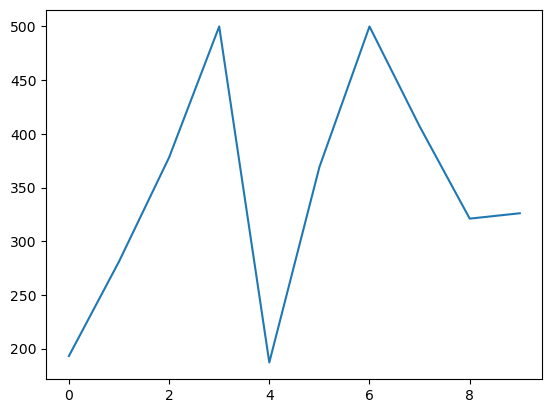

In [154]:
import matplotlib.pyplot as plt

plt.plot(N_k)

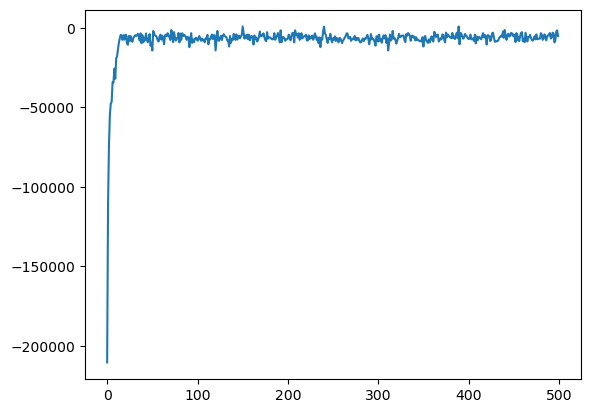

In [155]:
plt.plot(u_kln[0, -5, :] * kT)

In [165]:
DeltaF_ij = mbar.compute_free_energy_differences(compute_uncertainty=True)
DeltaF_ij_kj = mbar_kj.compute_free_energy_differences(compute_uncertainty=True)
# mbar.compute_free_energy_differences(compute_uncertainty=False)
print(
    "Free energy change to insert a particle = ",
    DeltaF_ij["Delta_f"][nstates - 1][0] * kT,
)

Free energy change to insert a particle =  1.1135043800498854 J/mol


In [166]:
DeltaF_ij_kj["Delta_f"][nstates - 1][0]

-0.1172064018107033

In [158]:
DeltaF_ij.keys()

dict_keys(['Delta_f', 'dDelta_f'])

In [159]:
de = np.array(DeltaF_ij["Delta_f"])

In [160]:
de[:, 0]

array([ 0.00000000e+00, -4.27957056e-05, -8.37892181e-05, -1.11612339e-04,
       -9.05290320e-05,  2.33307443e-06,  1.41817626e-04,  2.81253583e-04,
        3.86857938e-04,  4.46412647e-04])

In [161]:
de[0, :]

array([ 0.00000000e+00,  4.27957056e-05,  8.37892181e-05,  1.11612339e-04,
        9.05290320e-05, -2.33307443e-06, -1.41817626e-04, -2.81253583e-04,
       -3.86857938e-04, -4.46412647e-04])

In [162]:
DeltaF_ij["Delta_f"]

array([[ 0.00000000e+00,  4.27957056e-05,  8.37892181e-05,
         1.11612339e-04,  9.05290320e-05, -2.33307443e-06,
        -1.41817626e-04, -2.81253583e-04, -3.86857938e-04,
        -4.46412647e-04],
       [-4.27957056e-05,  0.00000000e+00,  4.09935125e-05,
         6.88166333e-05,  4.77333264e-05, -4.51287800e-05,
        -1.84613332e-04, -3.24049288e-04, -4.29653644e-04,
        -4.89208353e-04],
       [-8.37892181e-05, -4.09935125e-05,  0.00000000e+00,
         2.78231208e-05,  6.73981386e-06, -8.61222925e-05,
        -2.25606844e-04, -3.65042801e-04, -4.70647156e-04,
        -5.30201865e-04],
       [-1.11612339e-04, -6.88166333e-05, -2.78231208e-05,
         0.00000000e+00, -2.10833070e-05, -1.13945413e-04,
        -2.53429965e-04, -3.92865921e-04, -4.98470277e-04,
        -5.58024986e-04],
       [-9.05290320e-05, -4.77333264e-05, -6.73981386e-06,
         2.10833070e-05,  0.00000000e+00, -9.28621064e-05,
        -2.32346658e-04, -3.71782614e-04, -4.77386970e-04,
        -5.